In [6]:
from scipy.stats.stats import pearsonr
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pymc3 as pm

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')
df = df.drop(['Unnamed: 0','State'], axis=1)


infx = ['Chlamydia', 'Tuberculosis', 'Gonorrhea', 'HIV', 'senior_flu_deaths', 'Measles', 'Mumps', 'Pertussis', 'Rubella', 'varicella_hospitalizations', 'Salmonellosis', 'ecoli_hem', 'ecoli_nonhem', 'syphilis', 'botulism_dtfood']
qi = ['mort_30_ami', 'mort_30_cabg', 'mort_30_copd', 'mort_30_hf', 'mort_30_pn', 'mort_30_stk', 'readm_30_ami', 'readm_30_cabg', 'readm_30_copd', 'readm_30_hf', 'readm_30_hip_knee', 'readm_30_hosp_wide', 'readm_30_pn', 'readm_30_stk']
health_and_access = ['PC_PHYS_R', 'DENTIST_R', 'PSYCH_R','n_hospitals','cnty_obesity_pct_adj', 'cnty_dm_pct_adj', 'cnty_inactive_pct_adj', 'Adolescent_births', 'ABR', 'opiods_rx_1000', 'opiods_greater_than_stateavg','std', 'vaccine_dx', 'food_dx']
race = ['PCT_HSPNC', 'PCT_BLACK', 'PCT_ASIAN', 'PCT_AMIND_ESK', 'PCT_ISLANDER', 'PCT_MULTI', 'PCT_OTHER']
age = [ 'PCT_65OVER', 'PCT_18_64', 'PCT_UNDR18', 'PCT_UNDER5']
social = ['total_housing_units', 'pop_in_group_housing', 'pop_effected', 'p_hs_edatt','MILK_PRICE10', 'SODA_PRICE10', 'MILK_SODA_PRICE10', 'PCH_FFR_07_12', 'FFR07', 'FFR12']
base = ['County','des_percent', 'perc_lali']

df['pct_nonwhite'] =  1 - df['PCT_WHITE'] 
df = df.drop(race+infx, axis=1)
cols = df.columns.tolist()
df.head()

,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,perc_lali,...,food_dx,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12,pct_nonwhite
0,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,0.018032,...,29.597337,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211,0.483413
1,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,0.266288,...,0.000000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1,0.310400
2,Amador,38091,0,9,0.0,0.0,0,9,0.000000,0.149514,...,13.126460,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17,0.055533
3,Butte,220000,14,51,13.0,1.0,38,13,0.274510,0.145583,...,27.727273,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153,0.096562
4,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,0.203345,...,10.970205,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25,0.060800


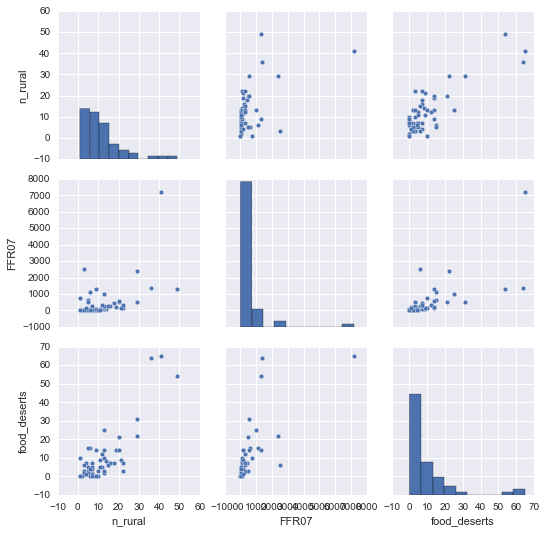

In [9]:
b = df[['n_rural','FFR07', 'food_deserts']].astype(int)
sns.pairplot(b)

In [12]:
Y = df['food_deserts'].values
X1=df['n_rural'].values
X2 = df['FFR07'].values

basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    mu = alpha + beta[0]*X1 + beta[1]*X2
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
    
#from pymc3 import find_MAP
map_estimate = pm.find_MAP(model=basic_model)
print(map_estimate)

Applied log-transform to sigma and added transformed sigma_log to model.
{'alpha': array(-3.1726598569777242), 'beta': array([ 0.87846633,  0.00503472]), 'sigma_log': array(1.6795551049435138)}


In [13]:
from scipy import optimize
map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)
print(map_estimate)

{'alpha': array(-3.095853251695182), 'beta': array([ 0.87065246,  0.00507273]), 'sigma_log': array(1.68129967865397)}


In [14]:
#from pymc3 import *
with basic_model:
    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    # instantiate sampler
    step = pm.NUTS(scaling=MAPstart)#, alpha=staalhpa)# draw 2000 posterior samples
    trace = pm.sample(2000, step, start=start)

NameError: name 'start' is not defined

In [ ]:
#from pymc3 import summary, traceplot 
pm.traceplot(trace)

The left column consists of a smoothed histogram (using kernel density estimation) of the marginalposteriors of each stochastic random variable while the right column contains the samples of the Markovchain plotted in sequential order. The beta variable, being vector-valued, produces two histograms andtwo sample traces, corresponding to both predictor coeﬃcients.In addition, the summary function provides a text-based output of common posterior statistics:

In [ ]:
pm.summary(trace)

Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2001 of 2000 complete in 2.0 sec

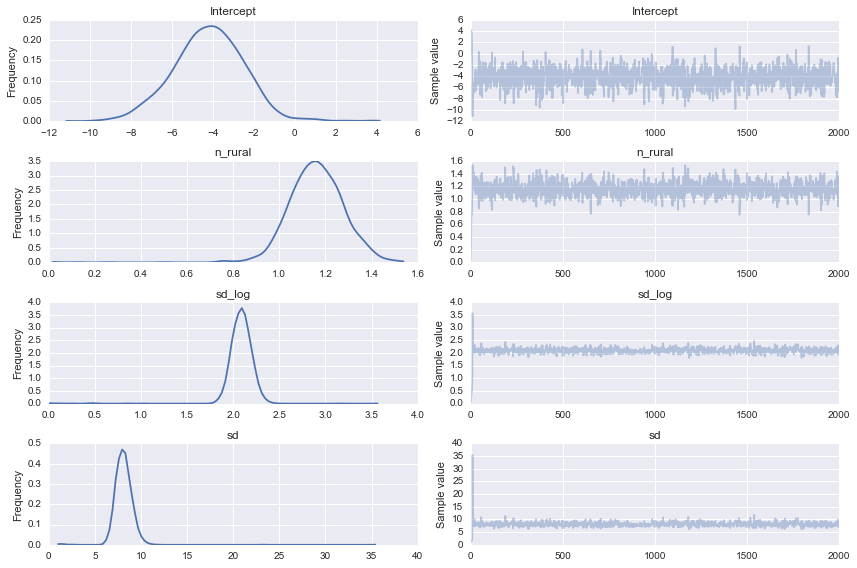

In [15]:


#from pymc3.glm import glm

model1=smf.ols(formula='food_deserts ~ n_rural',data=df).fit()
model1.params
pred=model1.predict(pd.DataFrame(df['n_rural']))
true_regression_line = pred#.values
x = df['n_rural'].values
y = df['food_deserts'].values
data = dict(x=x, y=y)


with pm.glm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    pm.glm.glm('food_deserts ~ n_rural',df)
    step = pm.NUTS() # Instantiate MCMC sampling algorithm
    trace = pm.sample(2000, step, progressbar=True) # draw 2000 posterior samples using NUTS sampling
    
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout();
# with Model() as model_glm:
#     glm('food_deserts ~ n_rural', df)
#     step = NUTS() # Instantiate MCMC sampling algorithm
#     trace = sample(2000, step, progressbar=True) # draw 2000 posterior samples using NUTS sampling

In [37]:
#help(trace)
trace['n_rural']#.variables

array([ 0.01707568,  0.01707568,  0.11468822, ...,  1.01291536,
        1.05294876,  1.01839   ])

KeyError: 'x'

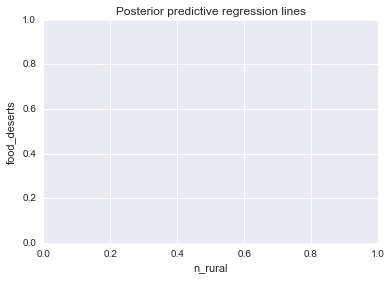

In [40]:

# plt.subplot(111, xlabel='n_rural', ylabel='food_deserts',
#             title='Posterior predictive regression lines')
# #plt.plot(x_out, y_out, 'x', label='data')
# pm.glm.plot_posterior_predictive(trace, samples=100,
#                                  label='posterior predictive regression lines')
# plt.plot(x, true_regression_line,
#          label='true regression line', lw=3., c='y')

# plt.legend(loc=0);
# # plt.figure(figsize=(7, 7))
# # plt.plot(df['n_rural'], y, label='data')
# # plt.plot(df['n_rural'], pred, label='true regression line', lw=3., c='y')

# # pm.glm.plot_posterior_predictive(trace['n_rural'], samples=50, label='posterior predictive regression lines')

# # plt.title('Posterior predictive regression lines')
# # plt.legend(loc=0)
# # plt.xlabel('x')
# # plt.ylabel('y');

In [4]:
# df = pd.read_csv('/Users/desert/desert_workspace/final_data.csv')
# df=df.drop('Unnamed: 0', axis=1)
# df.head()

In [5]:
# acc=pd.read_excel('/Users/desert/downloads/DataDownload.xls',sheetname=1)
# acc

In [6]:
# acc[acc['Variable Code'] == 'FFR12']
# acc[acc['Variable Code'] == 'PCH_FFR_07_12']

In [7]:
# acc['Category Code'].unique()
# #acc[acc['Category Code']=='PRICES_TAXES']
# #acc[acc['Category Code']=='ASSISTANCE']
# #acc[acc['Category Code']=='LOCAL']
# #acc[acc['Category Code']=='INSECURITY']
# #acc[acc['Category Code']=='ACCESS']
# #acc[acc['Category Code']=='STORES']
# tax=pd.read_excel('/Users/desert/downloads/DataDownload.xls',sheetname=9)
# tax=tax[['State','County','MILK_PRICE10','SODA_PRICE10','MILK_SODA_PRICE10']]
# tax= tax[tax['State']=='CA']
# tax=tax.drop('State',axis=1)
# tax.head()
# df = pd.merge(df,tax,how='inner',on='County')


In [8]:
# acc_df=pd.read_excel('/Users/desert/downloads/DataDownload.xls',sheetname=2)
# acc_df.head()

In [9]:
# #acc_df=pd.read_excel('/Users/desert/downloads/DataDownload.xls',sheetname=9)
# acc_df=pd.read_excel('/Users/desert/downloads/DataDownload.xls',sheetname=10)
# acc_df = acc_df[acc_df['State'] == 'CA']


In [10]:
# acc_df=acc_df[['County','PCH_FFR_07_12','FFR07','FFR12']]
# df=pd.merge(df,acc_df, how='inner',on='County')
# df

In [11]:
# df['std_ff']=standardize(df['FFR07'])
# sns.lmplot(x='FFR07',y='pop2010_in_des', data=df)

In [12]:
# df.columns.tolist()

In [13]:
# df.columns.tolist()
# data = df[['County','des_percent', 'PCH_FFR_07_12','Rural','Urban','cnty_obesity_pct','cnty_dm_pct','cnty_inactive_pct','percent_food_desert', 'pop2010_in_des','POP2010', 'ABR',
#  'p_hs_edatt','opiods_rx_1000']]
# #data['PCH_FFR_07_12']=data['PCH_FFR_07_12'] * 0.01
# data['cnty_obesity_pct']=data['cnty_obesity_pct'] * 0.01
# data['cnty_dm_pct']=data['cnty_dm_pct'] * 0.01
# data['cnty_inactive_pct']=data['cnty_inactive_pct'] * 0.01
# data['p_hs_edatt']=data['p_hs_edatt'] * 0.01
# data['ABR']=data['ABR'] * 0.01
# data['num_obese'] = np.round(data['cnty_obesity_pct'] * data['POP2010'])
# data['opiod_pop']=data['POP2010'] / 1000
# #data['opiods_rx_1000'] = data['opiods_rx_1000'] / 1000
# data['opiods_rx'] = data['opiods_rx_1000'] * data['opiod_pop']
# data['opiods_perc'] = data['opiods_rx'] / data['POP2010']

# data.head()
data = df.copy()
data.columns
data.describe()

,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,perc_lali,LowIncomeTracts,...,food_dx,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12,pct_nonwhite
count,5.800000e+01,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,6.423096e+05,9.258621,138.344828,8.396552,0.862069,126.758621,11.586207,0.142248,0.136505,57.275862,...,17.229751,913.333448,0.793103,1.033221,1.122320,0.851731,-0.513431,450.655172,478.586207,0.216768
std,1.416933e+06,13.965572,326.588832,13.536098,1.330457,321.227050,9.872937,0.150671,0.092349,153.543501,...,14.077325,351.304445,0.408619,0.046201,0.027179,0.033013,16.314735,1043.425811,1115.065603,0.114504
min,1.175000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.012594,0.000000,...,0.000000,419.640000,0.000000,0.996443,1.089488,0.815374,-50.000000,2.000000,1.000000,0.055200
25%,4.800075e+04,2.000000,11.000000,1.000000,0.000000,4.000000,5.000000,0.034053,0.055496,4.250000,...,10.861317,635.640000,1.000000,0.996443,1.089488,0.815374,-6.551100,28.250000,25.750000,0.123830
50%,1.791405e+05,5.000000,41.500000,3.500000,0.000000,29.000000,9.000000,0.079895,0.128088,15.500000,...,16.205939,829.490000,1.000000,1.026313,1.130546,0.866210,3.036530,119.500000,115.500000,0.209933
75%,6.425928e+05,10.000000,129.000000,10.000000,1.000000,113.000000,13.750000,0.203061,0.202444,51.750000,...,20.111540,1205.575000,1.000000,1.032918,1.130546,0.877073,8.820015,412.500000,387.750000,0.302111
max,9.818605e+06,65.000000,2334.000000,65.000000,5.000000,2293.000000,49.000000,0.750000,0.377328,1137.000000,...,101.336877,1829.160000,1.000000,1.122215,1.164422,0.891575,22.857143,7175.000000,7641.000000,0.483413


In [15]:
# data['majority_urban'] = data['Urban'] > 0.5
# data['majority_urban'] = data['majority_urban'].astype(int)
data['des'] = data['des_percent'] > 0.1
data['des'] = data['des'].astype(int)
# # def standardize(variable):
#     return (variable - np.mean(variable)) / np.std(variable)

# data['standardized_pop'] = standardize(data['POP2010'])
# data['standardized_des_pop'] = standardize(data['pop2010_in_des'])
# data['standardized_des_per'] =  standardize(data['pop2010_in_des']) #data['standardized_des_pop'] / data['standardized_pop']
# data.describe()
# data[data['standardized_des_per']>1.259362]
df[['food_deserts','n_hospitals']].dtypes


food_deserts      int64
n_hospitals     float64
dtype: object

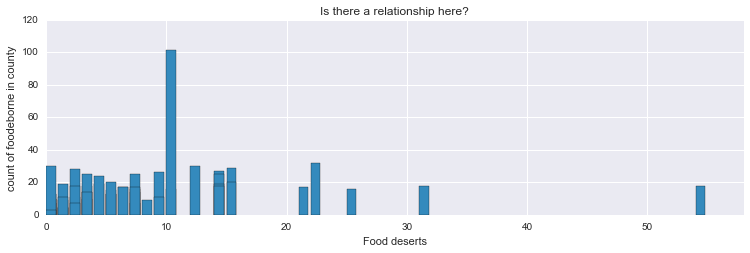

In [16]:
from IPython.core.pylabtools import figsize
import scipy.stats as stats
import pymc as pm

figsize(12.5, 3.5)
count_data = df[['food_deserts','food_dx']].astype(int)
n_count_data = len(df)
plt.bar(count_data['food_deserts'],count_data['food_dx'] , color="#348ABD")
plt.xlabel("Food deserts")
plt.ylabel("count of foodeborne in county")
plt.title("Is there a relationship here?")
plt.xlim(0, n_count_data);

In [17]:
count_data=count_data.set_index('food_deserts')
alpha = 1.0 / count_data.mean()  # Recall count_data is the
                               # variable that holds our txt counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [18]:
print "Random output:", tau.random(), tau.random(), tau.random()

Random output: 16 56 42


In [19]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

In [20]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [21]:
# Mysterious code to be explained in Chapter 3.
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 10.7 sec

In [22]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

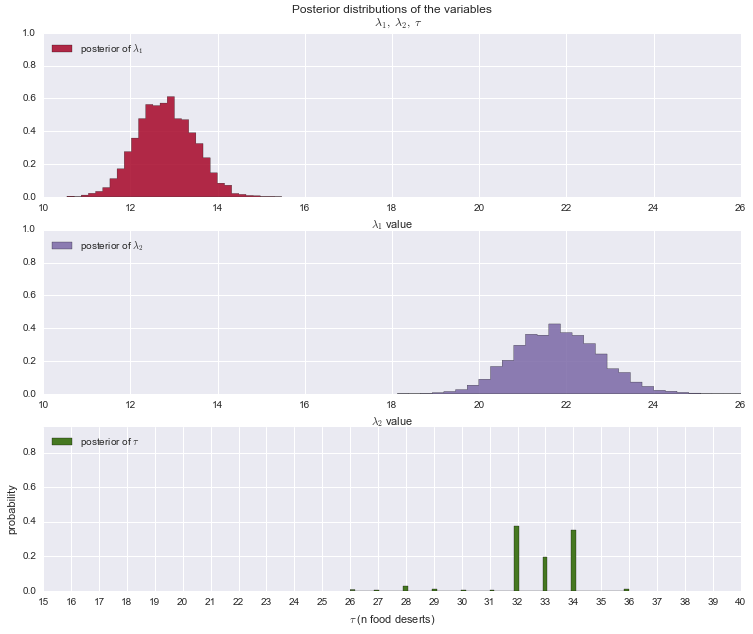

In [23]:
figsize(12.5, 10)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([10, 26])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([10, 26])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .95])
plt.xlim([15, 40])
plt.xlabel(r"$\tau$ (n food deserts)")
plt.ylabel("probability");

### Interpretation
Recall that Bayesian methodology returns a distribution. Hence we now have distributions to describe the unknown λs and τ. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: λ1 is around 18 and λ2 is around 23. The posterior distributions of the two λs are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.
What other observations can you make? If you look at the original data again, do these results seem reasonable?
Notice also that the posterior distributions for the λs do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. But that's OK! This is one of the benefits of taking a computational point of view. If we had instead done this analysis using mathematical approaches, we would have been stuck with an analytically intractable (and messy) distribution. Our use of a computational approach makes us indifferent to mathematical tractability.
Our analysis also returned a distribution for τ. Its posterior distribution looks a little different from the other two because it is a discrete random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of τ would have been more spread out, reflecting that many days were plausible candidates for τ. By contrast, in the actual results we see that only three or four days make any sense as potential transition points.
### Why would I want samples from the posterior, anyways?
We will deal with this question for the remainder of the book, and it is an understatement to say that it will lead us to some amazing results. For now, let's end this chapter with one more example.
We'll use the posterior samples to answer the following question: what is the expected number of texts at day t,0≤t≤70 ? Recall that the expected value of a Poisson variable is equal to its parameter λ. Therefore, the question is equivalent to what is the expected value of λ at time t?
In the code below, let i index samples from the posterior distributions. Given a day t, we average over all possible λi for that day t, using λi=λ1,i if t<τi (that is, if the behaviour change has not yet occurred), else we use λi=λ2,i.


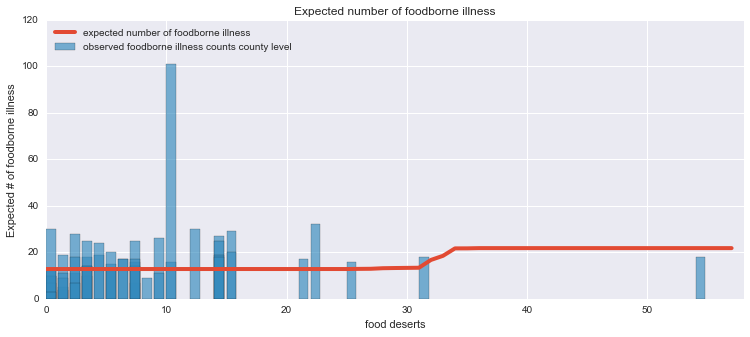

In [25]:
#count_data=count_data.set_index('food_deserts')

figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of foodborne illness")
plt.xlim(0, n_count_data)
plt.xlabel("food deserts")
plt.ylabel("Expected # of foodborne illness")
plt.title("Expected number of foodborne illness")
plt.ylim(0, 120)
count_data = count_data.reset_index()
plt.bar(count_data['food_deserts'],count_data.reset_index()['food_dx'] , color="#348ABD", alpha=0.65,
        label="observed foodborne illness counts county level")

plt.legend(loc="upper left");

Our analysis shows strong support for believing the user's behavior did change (λ1 would have been close in value to λ2 had this not been true), and that the change was sudden rather than gradual (as demonstrated by τ's strongly peaked posterior distribution). We can speculate what might have caused this: a cheaper text-message rate, a recent weather-to-text subscription, or perhaps a new relationship. (In fact, the 45th day corresponds to Christmas, and I moved away to Toronto the next month, leaving a girlfriend behind.)

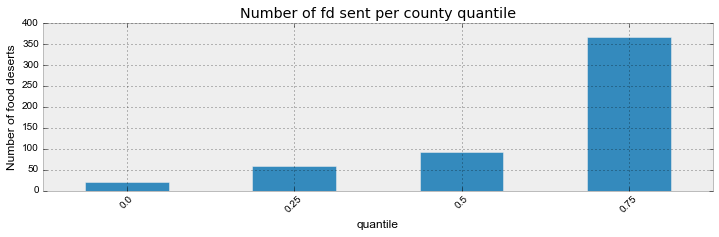

In [27]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns

from IPython.display import Image
from sklearn import preprocessing


%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

df['quant'] = np.nan

for q in [0.75, 0.5, 0.25]:
    df.loc[(df.POP2010 <= df.POP2010.quantile(q + 0.25)) & (df.POP2010 > df.POP2010.quantile(q)), 'quant'] = q

df.quant.fillna(0.0, inplace=True)

df
ax = df.groupby('quant')['food_deserts'].agg(np.sum).plot(
    kind='bar', figsize=(12,3), title='Number of fd per county quantile', color=colors[0])
_ = ax.set_xlabel('quantile')
_ = ax.set_ylabel('Number of food deserts')
_ = plt.xticks(rotation=45)

In [29]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(df['quant'])
participants = le.classes_
n_participants = len(participants)

for p in participants:
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)
        
        data = df[df['quant']==p]['food_deserts'].values
        y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=data)

        y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(20000, step, start=start, progressbar=True)
        
        indiv_traces[p] = trace

Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 8.0 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 5.9 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 6.4 secApplied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 8.1 sec

In [30]:
df

,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,perc_lali,...,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12,pct_nonwhite,quant
0,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,0.018032,...,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211,0.483413,0.75
1,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,0.266288,...,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1,0.310400,0.00
2,Amador,38091,0,9,0.0,0.0,0,9,0.000000,0.149514,...,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17,0.055533,0.00
3,Butte,220000,14,51,13.0,1.0,38,13,0.274510,0.145583,...,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153,0.096562,0.50
4,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,0.203345,...,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25,0.060800,0.00
5,Colusa,21419,1,5,1.0,0.0,2,3,0.200000,0.127574,...,836.42,1,1.032918,1.089488,0.877073,-16.666667,12.0,10,0.267450,0.00
6,Contra Costa,1049025,15,207,15.0,0.0,202,5,0.072464,0.037477,...,767.82,1,1.122215,1.164422,0.891575,1.768489,622.0,633,0.340155,0.75
7,Del Norte,28610,3,7,2.0,1.0,4,3,0.428571,0.258870,...,1604.28,1,0.996443,1.130546,0.815374,-21.428571,14.0,11,0.211000,0.00
8,El Dorado,181058,3,42,2.0,1.0,20,22,0.071429,0.103227,...,1066.12,1,1.032918,1.089488,0.877073,-15.966387,119.0,100,0.083140,0.50
9,Fresno,930450,31,199,26.0,5.0,170,29,0.155779,0.106664,...,635.82,1,0.996443,1.130546,0.815374,6.099815,541.0,574,0.306793,0.75


1
0
County
3
1
POP2010
3
2
quant


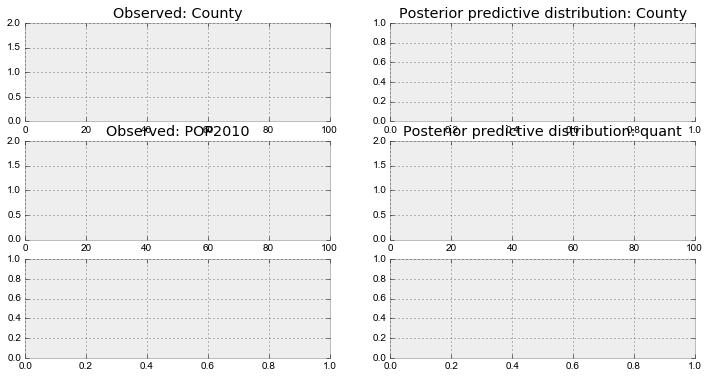

In [43]:
# fig, axs = plt.subplots(3,2, figsize=(12, 6))
# axs = axs.ravel()
# y_left_max = 2
# y_right_max = 2000
# x_lim = 60
# ix = [0,1,2,3,5,4,6,7,8,9,10]

data=df[['quant','food_deserts','County']]#.set_index('quant')
# ex = data.ix[ix]
# ex=ex.set_index('quant')
# for i, j, p in zip([0,1,2], [0,2,4], ex[ix]):
#     axs[j].set_title('Observed: %s' % p)
#     axs[j].hist(df[df['quant']==p]['food_deserts'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
#     axs[j].set_ylim([0, y_left_max])

# for i, j, p in zip([0,1,2], [1,3,5], ex[ix]):
#     axs[j].set_title('Posterior predictive distribution: %s' % p)
#     axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
#     axs[j].set_ylim([0, y_right_max])

# axs[4].set_xlabel('food_deserts')
# axs[5].set_xlabel('food_deserts')
# axs[5].set_xlabel('Response time (seconds)')

# plt.tight_layout()

fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2
y_right_max = 2000
x_lim = 100
ix = [0,1,-1]

df.set_index('')
for i, j, p in zip([0,1,2], [0,2,3], df[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(df[df['County']==p]['food_deserts'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,3], df[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    print j
    print i
    print p
    #axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    #axs[j].set_ylim([0, y_right_max])

#axs[4].set_xlabel('food_deserts))
#axs[5].set_xlabel('food_deserts))

#axs[5].set_xlabel('Response time (seconds)')


In [ ]:

combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.items()])

x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 20000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylim(0, 20)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

In [ ]:
bayes = data.groupby('majority_urban').agg(np.mean)#[['POP2010','num_obese','cnty_obesity_pct']]
bayes2 = data.groupby('des').agg(np.mean)#[['POP2010','num_obese','cnty_obesity_pct']]

In [ ]:
df.groupby(df['des_percent'] > 0.1).agg(np.mean)[['POP2010','pop2010_in_des','NUMGQTRS','HUNVFlag','PC_PHYS_R','DENTIST_R','PSYCH_R','PCT_HSPNC', 'PCT_BLACK','cnty_dm_pct', 'cnty_obesity_pct','PCT_65OVER','PCT_18_64','Rural','PCT_UNDR18','PCT_UNDER5','PCT_WHITE','unemployment_rate','p_hs_edatt','ABR']]


In [ ]:
#bayes=np.round(bayes)
bayes2

In [ ]:
corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('Data Correlations')
f.tight_layout()

In [ ]:
y = df['pop2010_in_des']
X = df['PCH_FFR_07_12']
linear_regression = smf.ols(formula='pop2010_in_des ~ PCH_FFR_07_12', data=df)
fitted_model = linear_regression.fit()
fitted_model.summary()


In [ ]:
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    contingency_table=pd.crosstab(index=df[c1], columns=df[c2])
    return chi2_contingency(contingency_table, correction=False)

test_stat, pval, deg_freedom, expected = chisq_of_df_cols(df, 'ama', 'readmitted_<30')


test_stat, pval

In [ ]:
from pymc import rbeta


class Discharges(object):

    """
    This class represents N discharge dispositions.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        dc( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """

    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def dc(self, i):
        # i is which arm to dc
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)


class BayesianStrategy(object):

    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        discharges: a Discharges class with .dc method
    
    methods:
        sample_discharges(n): sample and train on n dc.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """

    def __init__(self, discharges):

        self.discharges = discharges
        n_discharges = len(self.discharges)
        self.wins = np.zeros(n_discharges)
        self.trials = np.zeros(n_discharges)
        self.N = 0
        self.choices = []
        self.bb_score = []
        
    def sample_discharges(self, n=1):

        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # sample from the discharges's priors, and select the largest sample
            choice = np.argmax(rbeta(1 + self.wins, 1 + self.trials - self.wins))

            # sample the chosen discharge
            result = self.discharges.dc(choice)

            # update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [ ]:
from IPython.core.pylabtools import figsize
import scipy.stats as stats

figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)


def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha,
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                       colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("Posteriors After %d Samples" % bayesian_strategy.N +
                  "s" * (bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

In [ ]:
bayes2#.plot(kind='bar')
bayes2.drop(['pop2010_in_des','POP2010','opiods_rx_1000','num_obese','opiods_rx','opiod_pop'], axis=1).plot(kind='bar')

In [ ]:
true_p_A, true_p_B, N_A, N_B, observations_A, observations_B = gen_obs('cnty_dm_pct','POP2010',bayes2)

# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the deterministic delta function. This is our unknown of interest.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets.
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# To be explained in chapter 3.
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

In [ ]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

In [ ]:
def plot_AB(p_A_samples, true_p_A, p_B_samples, true_p_B, delta_samples):
    figsize(12.5, 10)
    ax = plt.subplot(311)
    plt.xlim(0, .1)
    plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,label="posterior of $p_A$", color="#A60628", normed=True)
    plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
    plt.legend(loc="upper right")
    plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")
    ax = plt.subplot(312)
    plt.xlim(0, .1)
    plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,label="posterior of $p_B$", color="#467821", normed=True)
    plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
    plt.legend(loc="upper right")
    ax = plt.subplot(313)
    plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,label="posterior of delta", color="#7A68A6", normed=True)
    plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",label="true delta (unknown)")
    plt.vlines(0, 0, 60, color="black", alpha=0.2)
    plt.legend(loc="upper right");

plot_AB(p_A_samples, true_p_A, p_B_samples, true_p_B, delta_samples)

In [ ]:
import pymc as pm
figsize(12, 4)

def gen_obs(prob_col,n_col,frame):
    true_p_A = frame[prob_col].ix[0]
    true_p_B = frame[prob_col].ix[1]
    N_A = np.round(frame[n_col].ix[0])
    N_B = np.round(frame[n_col].ix[1])
    observations_A = pm.rbernoulli(true_p_A, N_A)
    observations_B = pm.rbernoulli(true_p_B, N_B)
    print "Obs from Site A: ", observations_A[:30].astype(int), "..."
    print "Obs from Site B: ", observations_B[:30].astype(int), "..."
    return true_p_A, true_p_B, N_A, N_B, observations_A, observations_B
    
true_p_A, true_p_B, N_A, N_B, observations_A, observations_B = gen_obs('cnty_dm_pct','POP2010',bayes)
# # these two quantities are unknown to us.
# true_p_A = bayes['cnty_dm_pct'].ix[0]
# true_p_B = bayes['cnty_dm_pct'].ix[1]

# # notice the unequal sample sizes -- no problem in Bayesian analysis.
# N_A = np.round(bayes['POP2010'].ix[0])
# N_B = np.round(bayes['POP2010'].ix[1])

# # generate some observations
# observations_A = pm.rbernoulli(true_p_A, N_A)
# observations_B = pm.rbernoulli(true_p_B, N_B)
# print "Obs from Site A: ", observations_A[:30].astype(int), "..."
# print "Obs from Site B: ", observations_B[:30].astype(int), "..."

In [ ]:
print observations_A.mean()
print observations_B.mean()

In [ ]:

# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the deterministic delta function. This is our unknown of interest.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets.
obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# To be explained in chapter 3.
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

In [ ]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

In [ ]:
def plot_AB(p_A_samples, true_p_A, p_B_samples, true_p_B, delta_samples):
    figsize(12.5, 10)
    ax = plt.subplot(311)
    plt.xlim(0, .1)
    plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,label="posterior of $p_A$", color="#A60628", normed=True)
    plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
    plt.legend(loc="upper right")
    plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")
    ax = plt.subplot(312)
    plt.xlim(0, .1)
    plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,label="posterior of $p_B$", color="#467821", normed=True)
    plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
    plt.legend(loc="upper right")
    ax = plt.subplot(313)
    plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,label="posterior of delta", color="#7A68A6", normed=True)
    plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",label="true delta (unknown)")
    plt.vlines(0, 0, 60, color="black", alpha=0.2)
    plt.legend(loc="upper right");

plot_AB(p_A_samples, true_p_A, p_B_samples, true_p_B, delta_samples)
# ax = plt.subplot(312)


# figsize(12.5, 10)

# # histogram of posteriors

# ax = plt.subplot(311)

# plt.xlim(0, .1)
# plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
#          label="posterior of $p_A$", color="#A60628", normed=True)
# plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
# plt.legend(loc="upper right")
# plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

# ax = plt.subplot(312)

# plt.xlim(0, .1)
# plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
#          label="posterior of $p_B$", color="#467821", normed=True)
# plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
# plt.legend(loc="upper right")

# ax = plt.subplot(313)
# plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
#          label="posterior of delta", color="#7A68A6", normed=True)
# plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
#            label="true delta (unknown)")
# plt.vlines(0, 0, 60, color="black", alpha=0.2)
# plt.legend(loc="upper right");

In [ ]:
hidden_prob = bayes['cnty_obesity_pct'].values
discharges = Discharges(hidden_prob)
bayesian_strat = BayesianStrategy(discharges)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 300]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_discharges(i)
    plot_priors(bayesian_strat, hidden_prob)
    plt.legend(labels=['Prob of obesity: Rural','Majority_Urban'])#['home','rehab','LTC','nursing','psych']
    plt.autoscale(tight=True)
plt.tight_layout()

In [ ]:
hidden_prob = bayes['cnty_dm_pct'].values
discharges = Discharges(hidden_prob)
bayesian_strat = BayesianStrategy(discharges)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 300]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_discharges(i)
    plot_priors(bayesian_strat, hidden_prob)
    plt.legend(labels=['Majority_Rural','Majority_Urban'])#['home','rehab','LTC','nursing','psych']
    plt.autoscale(tight=True)
plt.tight_layout()

In [ ]:
hidden_prob = bayes['cnty_inactive_pct'].values
discharges = Discharges(hidden_prob)
bayesian_strat = BayesianStrategy(discharges)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 300]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_discharges(i)
    plot_priors(bayesian_strat, hidden_prob)
    plt.legend(labels=['Majority_Rural','Majority_Urban'])#['home','rehab','LTC','nursing','psych']
    plt.autoscale(tight=True)
plt.tight_layout()

In [ ]:

hidden_prob = bayes['p_hs_edatt'].values
discharges = Discharges(hidden_prob)
bayesian_strat = BayesianStrategy(discharges)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 300]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_discharges(i)
    plot_priors(bayesian_strat, hidden_prob)
    plt.legend(labels=['Majority_Rural','Majority_Urban'])#['home','rehab','LTC','nursing','psych']
    plt.autoscale(tight=True)
plt.tight_layout()